In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [86]:
# Setting matplotlib style
style.use('ggplot')

In [104]:
state_shutdown = pd.read_csv('./data/reopening_data/IL_full_reopen.csv')

In [105]:
state_shutdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85646 entries, 0 to 85645
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   username        85646 non-null  object 
 1   to              43220 non-null  object 
 2   text            85646 non-null  object 
 3   retweets        85646 non-null  int64  
 4   favorites       85646 non-null  int64  
 5   replies         85646 non-null  int64  
 6   id              85646 non-null  int64  
 7   permalink       85646 non-null  object 
 8   author_id       85646 non-null  int64  
 9   date            85646 non-null  object 
 10  formatted_date  85646 non-null  object 
 11  hashtags        11805 non-null  object 
 12  mentions        10688 non-null  object 
 13  geo             0 non-null      float64
 14  urls            21776 non-null  object 
 15  city            85646 non-null  object 
 16  query           85646 non-null  object 
 17  date_range      85646 non-null 

In [106]:
state_shutdown.groupby('city').count()['id'].sort_values(ascending=False)

city
chicago          56736
highland park     4750
elgin             3410
orland park       3082
naperville        2266
blue island       2042
gurnee            1639
st jacob          1380
champaign         1294
rockford          1242
bolingbrook        993
springfield        965
bristol            784
round lake         737
bloomington        709
marengo            570
peoria             491
marion             487
decatur            361
aurora             315
hecker             313
dixon              123
monmouth           112
fox lake           110
vandalia            79
macomb              77
harrisburg          63
freeport            57
nokomis             49
streator            44
melvin              34
marissa             33
jacksonville        32
tuscola             27
kewanee             27
vermont             23
farmington          21
onarga              21
san jose            21
carbondale          20
paw paw             18
mt carmel           18
sumner              14
enfiel

In [107]:
state_shutdown_df = state_shutdown.copy()[['username', 'text', 'date', 'city', 'state', 'month', 'day']]

In [108]:
state_shutdown_df['date'] = pd.to_datetime(state_shutdown_df['date'], utc=True)

In [109]:
# Creating year month day column because we'll need a way to sort dates across months
state_shutdown_df['year_month_day'] = state_shutdown_df['date'].dt.date

In [110]:
state_shutdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85646 entries, 0 to 85645
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   username        85646 non-null  object             
 1   text            85646 non-null  object             
 2   date            85646 non-null  datetime64[ns, UTC]
 3   city            85646 non-null  object             
 4   state           85646 non-null  object             
 5   month           85646 non-null  int64              
 6   day             85646 non-null  int64              
 7   year_month_day  85646 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 5.2+ MB


In [111]:
state_shutdown_df['year_month_day'].sort_values()

85645    2020-05-26
55743    2020-05-26
55744    2020-05-26
55745    2020-05-26
55746    2020-05-26
            ...    
2687     2020-06-09
2688     2020-06-09
2689     2020-06-09
2677     2020-06-09
0        2020-06-09
Name: year_month_day, Length: 85646, dtype: object

In [112]:
state_shutdown_df.groupby('year_month_day').count()

,username,text,date,city,state,month,day
year_month_day,,,,,,,
2020-05-26,5029,5029,5029,5029,5029,5029,5029
2020-05-27,5455,5455,5455,5455,5455,5455,5455
2020-05-28,5995,5995,5995,5995,5995,5995,5995
2020-05-29,6104,6104,6104,6104,6104,6104,6104
2020-05-30,5460,5460,5460,5460,5460,5460,5460
2020-05-31,7439,7439,7439,7439,7439,7439,7439
2020-06-01,7169,7169,7169,7169,7169,7169,7169
2020-06-02,6580,6580,6580,6580,6580,6580,6580
2020-06-03,6107,6107,6107,6107,6107,6107,6107


In [113]:
def plot_tweets_per_day(data):
    x = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    y = data.groupby('year_month_day').count()['username'] # Num tweets per day

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x, y, s=50, marker='o', color='darkred', zorder=3)
    sns.lineplot(x, y, color='red', linewidth=2.2)
    plt.axvline(x[3], color='blue') # 3rd day of search is the announcement date
    plt.title(f'Tweets per day in {data["state"][0]} surrounding Covid announcement date')
    plt.ylabel('Number of Tweets')
    plt.legend(labels=['_', 'Date shut-down announced'])
    plt.xlabel('Date');

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000022C52056B08> has a label of '_' which cannot be automatically added to the legend.
  # This is added back by InteractiveShellApp.init_path()


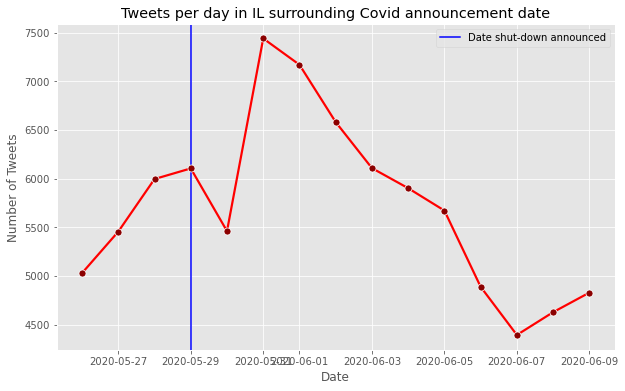

In [114]:
plot_tweets_per_day(state_shutdown_df)

Tweet activity steadily decreased in the weeks following the announcement of the shut-down in Illinois on **March 20, 2020**

In [102]:
def plot_top_and_bottom_tweeting_cities(data):
    top_tweeting_cities = data.groupby('city').count()['username'].sort_values().tail(10)
    bottom_tweeting_cities = data.groupby('city').count()['username'].sort_values().head(10)
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12))
    
    top_tweeting_cities.plot(kind='barh',
                         x=top_tweeting_cities.index,
                         y=top_tweeting_cities.values,
                         ax=ax[0],
                         color='darkred')

    ax[0].set_title(f'Top 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[0].set_ylabel('City Name', size=16)
    ax[0].set_xlabel('Number of Tweets', size=16)
    ax[0].set_yticklabels([label.title() for label in top_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12);
    
    bottom_tweeting_cities.plot(kind='barh',
                     x=bottom_tweeting_cities.index,
                     y=bottom_tweeting_cities.values,
                     ax=ax[1],
                     color='darkblue')

    ax[1].set_title(f'Bottom 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[1].set_ylabel('City Name', size=16)
    ax[1].set_xlabel('Number of Tweets', size=16)
    ax[1].set_yticklabels([label.title() for label in bottom_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12)
    plt.tight_layout();

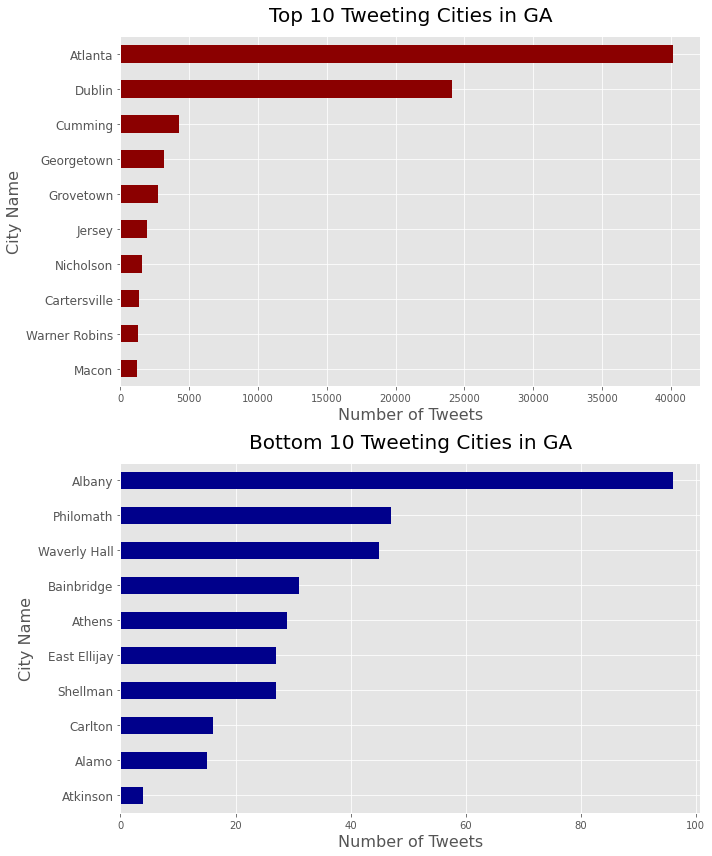

In [103]:
plot_top_and_bottom_tweeting_cities(state_shutdown_df)

**Note the drastic difference in scale!** The top three tweeting regions are Chicago, Blue Island, and Orland Park. Note that these may not be precise city areas, but regions, as our collection method involved the radius surrounding a city.

In [ ]:
city_tweets_per_day = state_shutdown_df.groupby(['city', 'year_month_day']).count()[['username']]

In [ ]:
city_tweets_per_day.T['chicago'].T.index

In [ ]:
def plot_city_tweets_per_day(data, city):
    '''
    Need to have "state_shutdown_df" defined
    '''
    sort_dates = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    city_tweets_per_day = data.groupby(['city', 'year_month_day']).count()[['username']]
    city_tweets_per_day.T[city].T.plot(figsize=(10, 6), linewidth=2.2, marker='o')
    plt.title(f'Tweets Over Time in {city.title()}')
    plt.axvline(sort_dates[3], color='darkblue')
    plt.legend(['_', 'Date of shutdown announcement']);

In [ ]:
plot_city_tweets_per_day(state_shutdown_df, 'chicago')

In [ ]:
plot_city_tweets_per_day(state_shutdown_df, 'blue island')

In [ ]:
plot_city_tweets_per_day(state_shutdown_df, 'rockford')

In [ ]:
plot_city_tweets_per_day(state_shutdown_df, 'springfield')

In [ ]:
plot_city_tweets_per_day(state_shutdown_df, 'elgin')

In [ ]:
plot_city_tweets_per_day(state_shutdown_df, 'bloomington')

In [ ]:
stop_words = ['http', 'https', 'igshid', 'becau']

In [ ]:
def tokenize_and_stem(text, stemmer=True):
    '''
    This does more than just tokenize and stem! The code removes links and
    html artifacts and is great for dirty data scraped from Reddit.
    
    Needs to be run within a loop to work properly.
    '''
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]

    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stem the tokens
    p_stemmer = PorterStemmer()
    return [p_stemmer.stem(i) for i in tokens]

def tokenize(text):
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]
    
    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [ ]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [ ]:
cvec_processed_sw = tokenize(' '.join(custom_sw))

cvec = CountVectorizer(stop_words=custom_sw, tokenizer=tokenize)
cvec_fit = cvec.fit(state_shutdown_df['text'])
cvec_transform = cvec.transform(state_shutdown_df['text'])

cvec_df = pd.DataFrame(cvec_transform.todense(),
                 columns=cvec_fit.get_feature_names())

cvec_df.head()

In [ ]:
top_words_cvec = {}
for column in tqdm(cvec_df.columns):
    top_words_cvec[column] = cvec_df[column].sum()

most_freq_cvec = pd.DataFrame(sorted(top_words_cvec.items(), key = lambda x: x[1], reverse=True))

In [ ]:
most_freq_cvec.to_csv('./data/top_words_cvec_il.csv', index=False)

In [ ]:
most_freq_cvec.head(200)[0].tolist()